In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import *

### 高斯模板

In [43]:
def gauss_model(size, variance):
    result = np.zeros((size,size))
    sum = 0.
    #二阶高斯函数
    for i in range(size):
        for j in range(size):
            result[i][j] = np.exp(-((int(i-(size-1)/2))**2 + \
                                    (int(j-(size-1)/2))**2)/(2*variance)) / (2*variance*np.pi)
            sum += result[i][j]
    #归一化
    for i in range(size):
        for j in range(size):
            result[i][j] = result[i][j] / sum
    return result

In [3]:
print(gauss_model(5,2))

[[0.01247764 0.02641517 0.03391775 0.02641517 0.01247764]
 [0.02641517 0.05592091 0.07180387 0.05592091 0.02641517]
 [0.03391775 0.07180387 0.09219799 0.07180387 0.03391775]
 [0.02641517 0.05592091 0.07180387 0.05592091 0.02641517]
 [0.01247764 0.02641517 0.03391775 0.02641517 0.01247764]]


### 高斯滤波

In [4]:
image = cv2.imread('D:3.jpg')

In [5]:
#求感受野
def feel_area(image, size, height):
    alls = []
    for i in range(len(image) - size + 1):
        for j in range(len(image[0]) - size + 1):
            temp = np.zeros((size,size))
            for m in range(size):
                for n in range(size):
                    temp[m][n] = image[i+m][j+n][height]
            alls.append(temp)
    return alls


In [6]:
#卷积计算方法
def conovl(model,area):
    sum = 0
    for i in range(len(model)):
        for j in range(len(model[0])):
            sum += model[i][j] * area[i][j]
    return sum/255

In [7]:
#计算卷积后大小
def cov_size(image,size):
    w =int((len(image[0])-size)/1+1)
    h = int((len(image)-size)/1+1)
    return w,h
#高斯滤波函数
def convolution(iamge,size,var,height):
    w,h = cov_size(image,size)
    cov_result = np.zeros((h,w))
    model = gauss_model(size, var)
    feel_model = feel_area(image, size,height)
    for i in range(h):
        for j in range(w):
            cov_result[i][j] = conovl(feel_model[i * w + j],model)
    return cov_result

In [8]:
#对三个通道分别进行滤波，然后结合
def get_new_image(image,size,var):
    ren_image = convolution(image,size,var,0)
    ren1_image = convolution(image,size,var,1)
    ren2_image = convolution(image,size,var,2)
    image_result = np.dstack([ren_image,ren1_image,ren2_image])
    return image_result

In [9]:
image_result = get_new_image(image,7,3)
img = cv2.normalize(image_result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("3_cov3.jpg",img)

True

### canny算法

##### 加载图片，变成灰度图

In [10]:
image = cv2.imread("3.jpg")
img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
cv2.imwrite("3_gray.jpg",img)

True

##### 平滑

In [11]:
gaussian = gauss_model(5, 1)
w1, h1 = img.shape
new_gray = np.zeros([w1-5, h1-5])
for i in range(w1-5):
    for j in range(h1-5):
        new_gray[i,j] = np.sum(img[i:i+5,j:j+5]*gaussian)/255

img1 = cv2.normalize(new_gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("3_cov_gray.jpg",img1)

True

##### 梯度强度和方向

In [13]:
#new_gray0 = cv2.normalize(new_gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
w2, h2 = new_gray.shape
dx = np.zeros([w2-1, h2-1])
dy = np.zeros([w2-1, h2-1])
d = np.zeros([w2-1, h2-1])
for i in range(w2-1):
    for j in range(h2-1):
        dx[i,j] = (new_gray[i+1,j-1] + 2*new_gray[i+1,j] + new_gray[i+1,j+1]) - (new_gray[i-1,j-1]+2*new_gray[i-1,j]+new_gray[i-1,j+1])
        dy[i,j] = (new_gray[i-1,j-1] + 2*new_gray[i,j-1] + new_gray[i+1,j-1]) - (new_gray[i-1,j+1]+2*new_gray[i,j+1]+new_gray[i+1,j+1])
        d[i, j] = np.sqrt(np.square(dx[i,j]) + np.square(dy[i,j]))
#plt.figure()
#plt.imshow(d,cmap='gray')
#plt.show()
#cv2.imshow('3',d)
#cv2.waitKey(0)
d1 = cv2.normalize(d, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("3_cov_gray_gd.jpg",d1)

True

##### 非极大化抑制

In [14]:
w3, h3 = d.shape
NMS = np.copy(d)
NMS[0,:] = NMS[w3-1,:] = NMS[:,0] = NMS[:, h3-1] = 0
for i in range(1, w3-1):
    for j in range(1, h3-1):
        if d[i, j] == 0:
            NMS[i, j] = 0
        else:
            gradX = dx[i, j]
            gradY = dy[i, j]
            gradTemp = d[i, j]
            
            if np.abs(gradY) > np.abs(gradX):
                weight = np.abs(gradX) / np.abs(gradY)
                grad2 = d[i-1, j]
                grad4 = d[i+1, j]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i-1, j-1]
                    grad3 = d[i+1, j+1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i-1, j+1]
                    grad3 = d[i+1, j-1]
                    
            # 如果X方向幅度值较大
            else:
                weight = np.abs(gradY) / np.abs(gradX)
                grad2 = d[i, j-1]
                grad4 = d[i, j+1]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i+1, j-1]
                    grad3 = d[i-1, j+1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i-1, j-1]
                    grad3 = d[i+1, j+1]
        
            gradTemp1 = weight * grad2 + (1-weight) * grad1
            gradTemp2 = weight * grad4 + (1-weight) * grad3
            if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                NMS[i, j] = gradTemp
            else:
                NMS[i, j] = 0
#plt.figure()
#plt.imshow(NMS,cmap = 'gray')
#plt.show()
#cv2.imshow('3',NMS)
#cv2.waitKey(0)
NMS1 = cv2.normalize(NMS, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("3_cov_gray_gd_NMS.jpg",NMS1)

True

##### 高低阈值和抑制孤立比较低的阈值点

In [16]:
w4, h4 = NMS.shape
DT = np.zeros([w4, h4])               
# 定义高低阈值
TL = 0.15* np.max(NMS)
TH = 0.4 * np.max(NMS)
for i in range(1, w4-1):
    for j in range(1, h4-1):
        if (NMS[i, j] < TL):
            DT[i, j] = 0
        elif (NMS[i, j] > TH):
            DT[i, j] = 1
        elif ((NMS[i-1, j-1:j+1] < TH).any() or (NMS[i+1, j-1:j+1] < TH).any() or (NMS[i, [j-1, j+1]] < TH).any()):
            DT[i, j] = 1

DT1 = cv2.normalize(DT, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("3_cov_gray_gd_NMS_dt.jpg",DT1)

True

### harris算法

###### 加载图片并且灰度值

In [23]:
image = cv2.imread("3.jpg")
img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#cv2.imshow("0",img)
#cv2.waitKey(0)

##### 平滑

In [24]:
gaussian = gauss_model(5, 1)
w, h = img.shape
new_gray = np.zeros([w-5, h-5])
for i in range(w-5):
    for j in range(h-5):
        new_gray[i,j] = np.sum(img[i:i+5,j:j+5]*gaussian)/255
#print(new_gray)
#cv2.imshow("0",new_gray)
#cv2.waitKey(0)
#n = cv2.normalize(new_gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

##### 计算梯度

In [25]:
w1, h1 = new_gray.shape
dx = np.zeros([w1-1,h1-1])
dy = np.zeros([w1-1, h1-1])
d = np.zeros([w1-1, h1-1])
for i in range(w1-1):
    for j in range(h1-1):
        dx[i,j] = (new_gray[i+1,j-1] + 2*new_gray[i+1,j] + new_gray[i+1,j+1]) - (new_gray[i-1,j-1]+2*new_gray[i-1,j]+new_gray[i-1,j+1]) 
        dy[i,j] = (new_gray[i-1,j-1] + 2*new_gray[i,j-1] + new_gray[i+1,j-1]) - (new_gray[i-1,j+1]+2*new_gray[i,j+1]+new_gray[i+1,j+1])
        d[i, j] = np.sqrt(np.square(dx[i,j]) + np.square(dy[i,j]))
#plt.figure()
#plt.imshow(d,cmap='gray')
#plt.show()
#cv2.imshow('3',d)
#cv2.waitKey(0)

##### 计算梯度平方

In [29]:
w2,h2 = d.shape
lxx = np.zeros([w2,h2])
lyy = np.zeros([w2,h2])
lxy = np.zeros([w2,h2])
for i in range(w2):
    for j in range(h2):
        lxx[i,j] = dx[i,j]*dx[i,j]
        lyy[i,j] = dy[i,j]*dy[i,j]
        lxy[i,j] = dx[i,j]*dy[i,j]

##### 计算梯度像素和

In [30]:
gaussian1 = gauss_model(5, 1)
sxx = np.zeros([w2-5,h2-5])
syy = np.zeros([w2-5,h2-5])
sxy = np.zeros([w2-5,h2-5])

for i in range(w2-5):
    for j in range(h2-5):
        sxx[i,j] = np.sum(lxx[i:i+5,j:j+5]*gaussian1)
        syy[i,j] = np.sum(lyy[i:i+5,j:j+5]*gaussian1)
        sxy[i,j] = np.sum(lxy[i:i+5,j:j+5]*gaussian1) 

##### 计算Harris矩阵和R值

In [31]:
w3,h3 = sxy.shape
R = np.zeros([w3,h3])
maxR = 0.
for i in range(w3):
    for j in range(h3):
        temp = mat([[sxx[i,j],sxy[i,j]],[sxy[i,j],syy[i,j]]])
        R[i,j] = np.linalg.det(temp) - 0.05*(temp.trace()**2)
        if R[i,j] > maxR:
            maxR = R[i,j]

##### 非极大化抑制和按照阈值找到角点

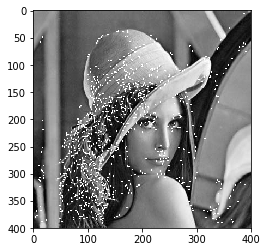

True

In [32]:
img14 = np.copy(img)
w4,h4 = R.shape
#print(R)
for i in range(1,w4-1):
    for j in range(1,h4-1):
        if R[i,j] > 0.0001*maxR and R[i,j] > R[i-1,j-1] and R[i,j] > R[i-1,j] and R[i,j] > R[i-1,j+1] and R[i,j] > R[i,j-1] and R[i,j] > R[i,j+1] and R[i,j] > R[i+1,j-1] and R[i,j] > R[i+1,j] and R[i,j] > R[i+1,j+1]:
            #font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(img14,'x',(j+5,i+5), font, 0.1,(255,0,0),1)
            cv2.circle(img14,(j+3,i+3),1,(255,0,0),-1)
plt.figure()
plt.imshow(img14,cmap = 'gray')
plt.show()
#cv2.imshow('3',img14)
#cv2.waitKey(0)
Harris = cv2.normalize(img14, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite("harris_1.jpg",img14)

### SIFT算法

##### 读取图像以及灰度化

In [33]:
img_sift = cv2.imread("3.jpg")
img_s = cv2.cvtColor(img_sift,cv2.COLOR_RGB2GRAY)

##### 调库寻找sift特征点

In [34]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_s,None)
img_s1=cv2.drawKeypoints(img_s,kp,img_sift)
cv2.imwrite("sift.jpg",img_s1)
#cv2.waitKey(0)

True

##### 验证状态不变性

In [38]:
def two_img_sift(img1 , img2 ,path):  
    Img1 = cv2.imread(img1)
    Img2 = cv2.imread(img2)
    
    # 创建识别器
    detector = cv2.xfeatures2d.SIFT_create(200)
    
    # 计算KeyPoints
    kp1 , des1 = detector.detectAndCompute(Img1,None)
    kp2 , des2 = detector.detectAndCompute(Img2,None)
    
    # 创建BFMatcher
    bf = cv2.BFMatcher()
    matchers = bf.knnMatch(des1 , des2 , k=2)
    
    # 创建相似列表
    Match = []
    for m,n in matchers:
        if m.distance <  0.50*n.distance:
            Match.append(m)
            
    height1 , width1 = Img1.shape[:2]
    height2 , width2 = Img2.shape[:2]
    
    # 像素调整
    vis = np.zeros((max(height1, height2), width1 + width2, 3), np.uint8)
    vis[:height1, :width1] = Img1
    vis[:height2, width1:width1 + width2] = Img2
    
    p1 = [kpp.queryIdx for kpp in Match[:20]]
    p2 = [kpp.trainIdx for kpp in Match[:20]]

    post1 = np.int32([kp1[pp].pt for pp in p1])
    post2 = np.int32([kp2[pp].pt for pp in p2]) + (width1, 0)
    
    
    for (x1, y1), (x2, y2) in zip(post1, post2):
        cv2.line(vis, (x1, y1), (x2, y2), (0,0,255))
    
    cv2.imwrite(path,vis)
    #cv2.namedWindow("match",cv2.WINDOW_NORMAL)
    #cv2.imshow("match", vis)    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

##### 旋转不变性

In [40]:
path1 = r"D:\3_gray.jpg"
path2 = r"D:\3_gray_0.jpg"
path3 = "tran.jpg"
two_img_sift(path1 , path2, path3)

##### 亮度不变性

In [41]:
path1 = r"D:\3_gray_3.jpg"
path2 = r"D:\3_gray_0.jpg"
path3 = "light.jpg"
two_img_sift(path1 , path2, path3)

##### 缩放不变性

In [42]:
path1 = r"D:\3_gray_2.jpg"
path2 = r"D:\3_gray_0.jpg"
path3 = "shrink.jpg"
two_img_sift(path1 , path2, path3)